Dynamic Pricing Recommendations:
      Item  Hour Status  BasePrice  DemandLevel Adjustment  NewPrice
      Milk 08:00   Open       26.0     0.769231         0%     26.00
      Milk 09:00   Open       26.0     1.000000        25%     32.50
      Milk 10:00   Open       26.0     0.653846         0%     26.00
      Milk 11:00   Open       26.0     0.807692         6%     27.50
      Milk 12:00   Open       26.0     0.115385       -17%     21.50
      Milk 13:00   Open       26.0     0.461538         0%     26.00
      Milk 14:00   Open       26.0     0.500000         0%     26.00
      Milk 15:00   Open       26.0     0.423077         0%     26.00
      Milk 16:00   Open       26.0     0.307692         0%     26.00
      Milk 17:00   Open       26.0     0.538462         0%     26.00
      Milk 18:00   Open       26.0     0.423077         0%     26.00
      Milk 19:00   Open       26.0     0.500000         0%     26.00
      Milk 20:00   Open       26.0     0.500000         0%     26.00
 

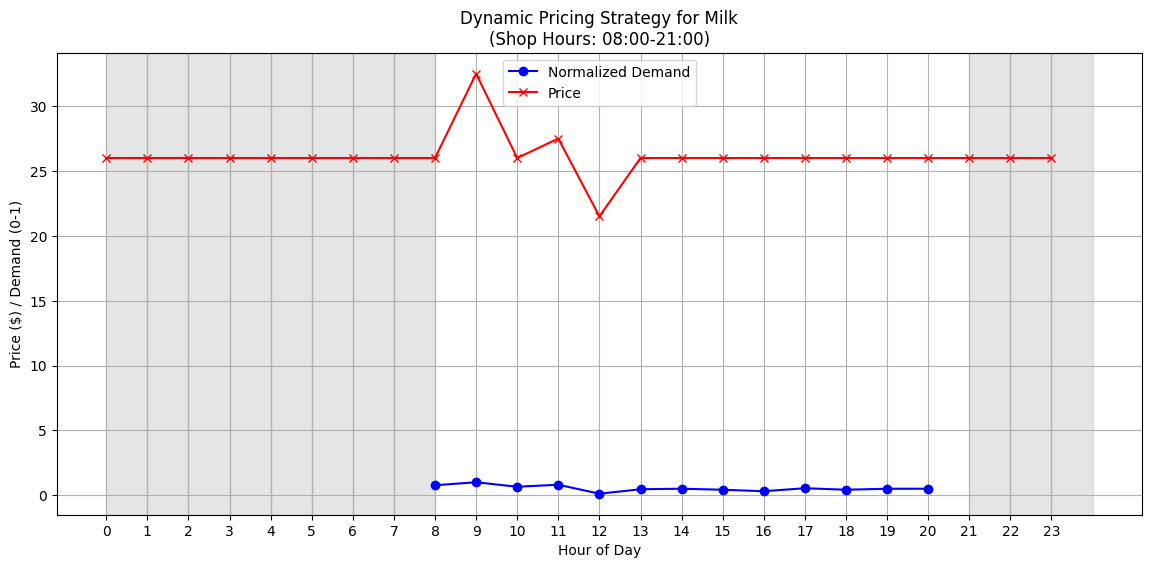

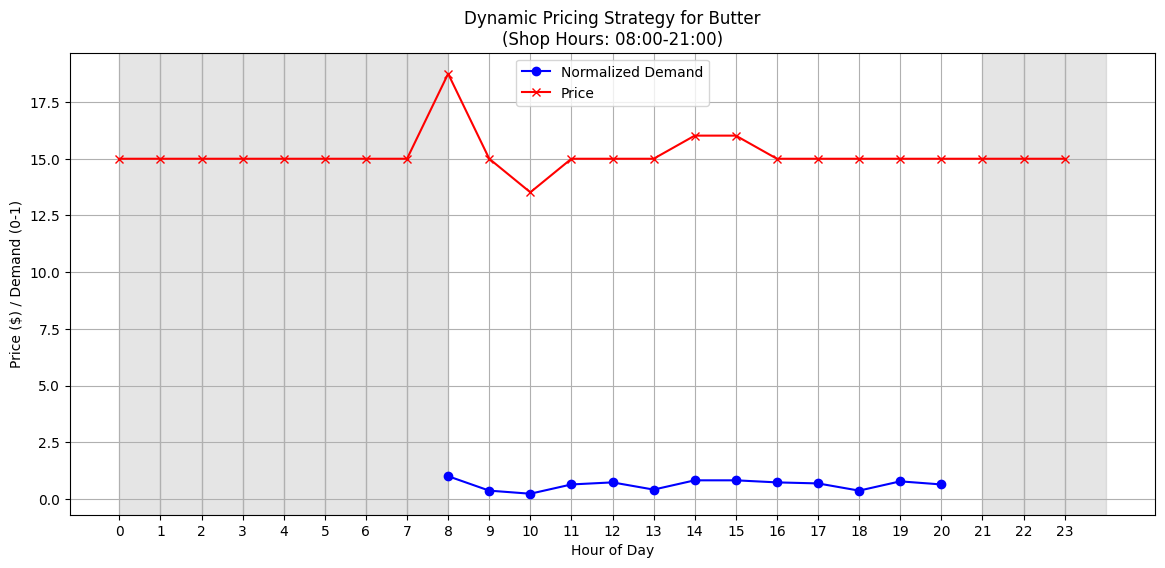

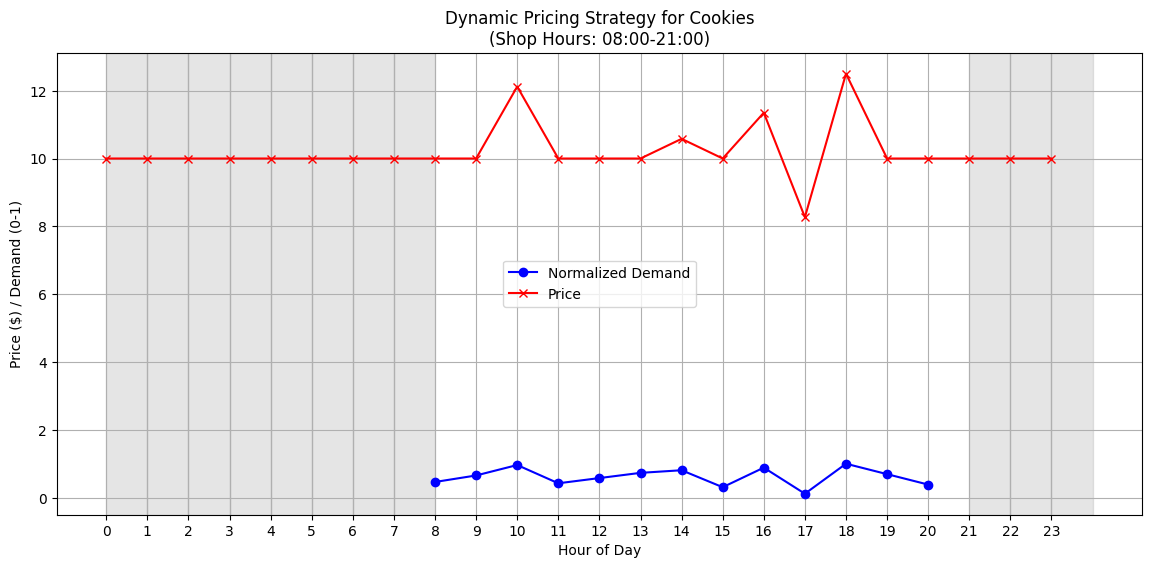

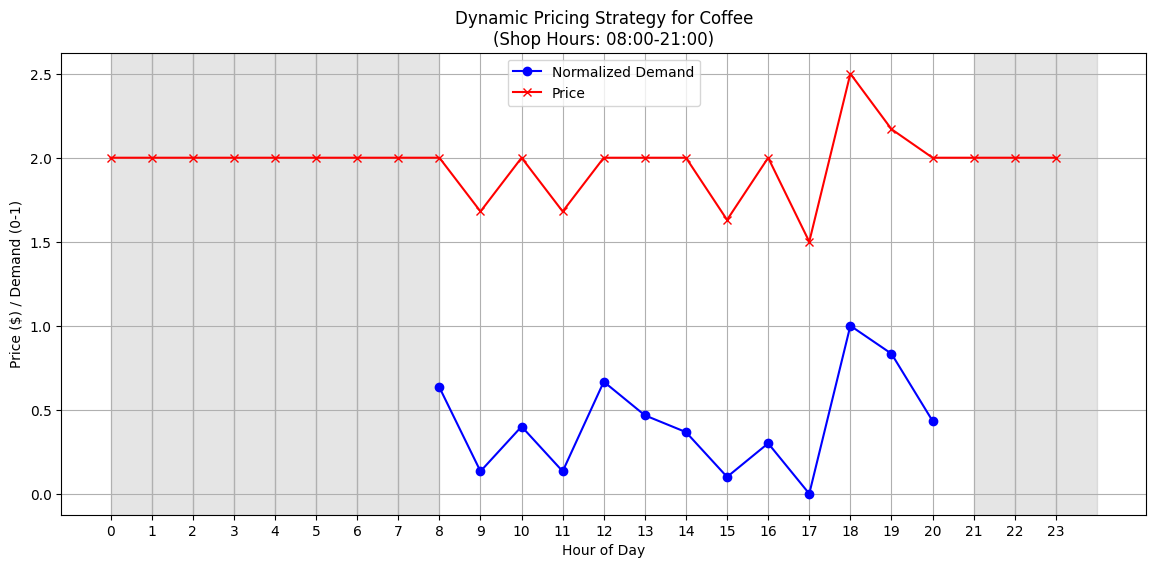

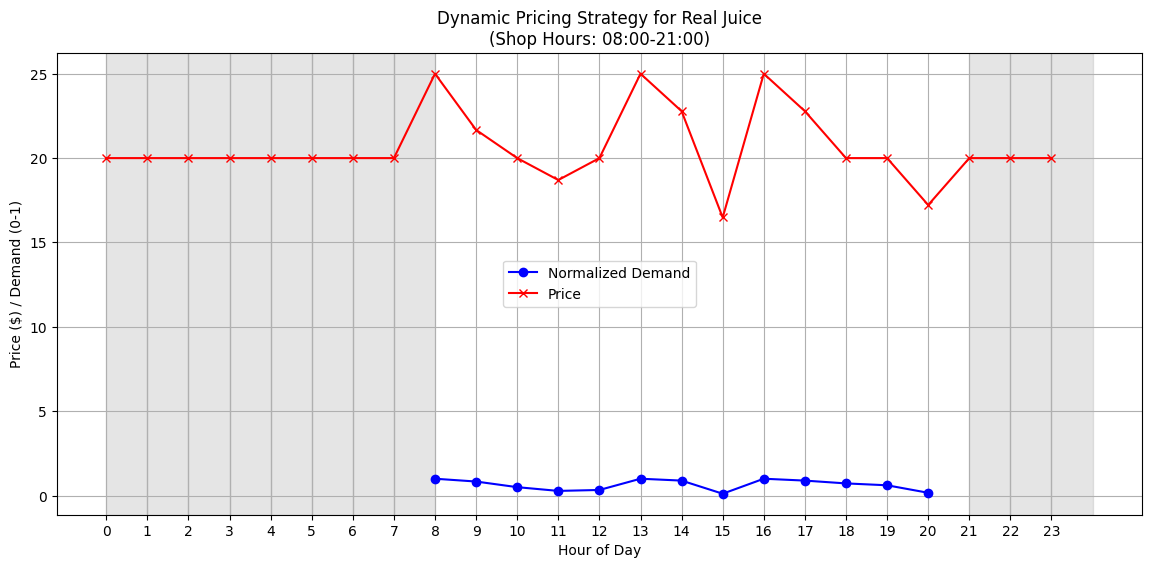

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time

# Load and preprocess data
def load_data(file_path):
    xls = pd.ExcelFile(file_path)
    df = pd.read_excel(xls, sheet_name="Sheet1")

    # Clean and structure the data
    data = []
    for _, row in df.iterrows():
        items = str(row['Purchased_Items']).split(',')
        quantities = str(row['Quantities']).split(',')
        prices = str(row['Prices_per_Unit']).split(',')

        # Handle cases where quantity/price might be invalid
        for i in range(min(len(items), len(quantities), len(prices))):
            try:
                item = items[i].strip()
                qty = float(quantities[i].strip())
                price = float(prices[i].strip())
                purchase_time = pd.to_datetime(row['Time_of_Purchase']).time()
                hour = purchase_time.hour

                data.append({
                    'Item': item,
                    'Quantity': qty,
                    'Price': price,
                    'Hour': hour
                })
            except:
                continue

    return pd.DataFrame(data)

# Dynamic pricing engine with operating hours
class DynamicPricingEngine:
    def __init__(self, data, min_change=0.05, max_change=0.25, open_hours=(8, 21)):
        self.data = data
        self.min_change = min_change
        self.max_change = max_change
        self.open_start = open_hours[0]
        self.open_end = open_hours[1]
        self.base_prices = self.calculate_base_prices()
        self.hourly_demand = self.calculate_hourly_demand()

    def calculate_base_prices(self):
        return self.data.groupby('Item')['Price'].median().to_dict()

    def calculate_hourly_demand(self):
        # Only consider hours when shop is open
        open_hours_data = self.data[
            (self.data['Hour'] >= self.open_start) &
            (self.data['Hour'] < self.open_end)
        ]
        hourly = open_hours_data.groupby(['Item', 'Hour'])['Quantity'].sum().unstack(fill_value=0)
        # Normalize demand to 0-1 scale
        return hourly.div(hourly.max(axis=1), axis=0)

    def is_shop_open(self, hour):
        return self.open_start <= hour < self.open_end

    def get_price_adjustment(self, item, hour):
        if not self.is_shop_open(hour):
            return 0  # No adjustment when shop is closed

        if item not in self.hourly_demand.index:
            return 0  # No change for items not in our analysis

        demand = self.hourly_demand.loc[item, hour]
        base_price = self.base_prices[item]

        # Implement pricing rules with no-change zones
        if demand > 0.8:  # High demand
            adjustment = self.min_change + (demand - 0.8) * ((self.max_change - self.min_change) / 0.2)
        elif demand < 0.3:  # Low demand
            adjustment = -self.min_change - (0.3 - demand) * ((self.max_change - self.min_change) / 0.3)
        else:  # Moderate demand - no change
            adjustment = 0

        # Ensure adjustment stays within bounds
        adjustment = np.clip(adjustment, -self.max_change, self.max_change)
        return adjustment

    def generate_pricing_table(self, items=None, hours=range(24)):
        if items is None:
            items = self.hourly_demand.index

        pricing_data = []
        for item in items:
            for hour in hours:
                adjustment = self.get_price_adjustment(item, hour)
                base_price = self.base_prices[item]
                new_price = round(base_price * (1 + adjustment), 2)
                status = "Open" if self.is_shop_open(hour) else "Closed"

                pricing_data.append({
                    'Item': item,
                    'Hour': f"{hour:02d}:00",
                    'Status': status,
                    'BasePrice': base_price,
                    'DemandLevel': self.hourly_demand.loc[item, hour] if status == "Open" else np.nan,
                    'Adjustment': f"{int(round(adjustment * 100))}%" if status == "Open" else "0% (Closed)",
                    'NewPrice': new_price
                })

        return pd.DataFrame(pricing_data)

    def plot_pricing_strategy(self, item):
        plt.figure(figsize=(14, 6))

        # Generate data for plotting
        pricing = self.generate_pricing_table(items=[item])
        hours = range(24)
        prices = [pricing[pricing['Hour'] == f"{h:02d}:00"]['NewPrice'].values[0] for h in hours]
        demand = [pricing[pricing['Hour'] == f"{h:02d}:00"]['DemandLevel'].values[0] for h in hours]

        # Plot demand curve (only for open hours)
        open_hours = [h for h in hours if self.is_shop_open(h)]
        open_demand = [d for h, d in zip(hours, demand) if self.is_shop_open(h)]
        plt.plot(open_hours, open_demand,
                label='Normalized Demand', color='blue', marker='o')

        # Plot price adjustments
        plt.plot(hours, prices,
                label='Price', color='red', marker='x', linestyle='-')

        # Highlight open/closed periods
        for h in hours:
            if not self.is_shop_open(h):
                plt.axvspan(h, h+1, color='gray', alpha=0.2)

        plt.title(f'Dynamic Pricing Strategy for {item}\n(Shop Hours: {self.open_start:02d}:00-{self.open_end:02d}:00)')
        plt.xlabel('Hour of Day')
        plt.ylabel('Price ($) / Demand (0-1)')
        plt.xticks(range(24))
        plt.legend()
        plt.grid(True)
        plt.show()

# Main execution
if __name__ == "__main__":
    # Load data
    df = load_data("dmafinalaf.xlsx")

    # Initialize pricing engine with:
    # - 5-25% adjustment range
    # - Operating hours 8 AM (8) to 9 PM (21)
    engine = DynamicPricingEngine(df, min_change=0.05, max_change=0.25, open_hours=(8, 21))

    # Get top 5 items
    top_items = df.groupby('Item')['Quantity'].sum().nlargest(5).index

    # Generate and display pricing table
    pricing_table = engine.generate_pricing_table(items=top_items)
    print("Dynamic Pricing Recommendations:")
    print(pricing_table[pricing_table['Status'] == 'Open'].to_string(index=False))  # Only show open hours

    # Visualize strategy for each top item
    for item in top_items:
        engine.plot_pricing_strategy(item)